### VisionExplainer for image classification

The class `VisionExplainer` is designed for vision tasks, acting as a factory of the supported vision explainers such as integrated-gradient and Grad-CAM. `VisionExplainer` provides a unified easy-to-use interface for all the supported explainers. In practice, we recommend applying `VisionExplainer` to generate explanations instead of using a specific explainer in the package `omnixai.explainers.vision`.

In [1]:
import sys
import os

module_path = os.path.abspath('E:/Codes/OmniXAI/omnixai/')
if module_path not in sys.path:
    sys.path.append(module_path)

# For Jupyter notebooks or interactive environments where __file__ is not defined
try:
    # Try to use __file__ if available
    directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If __file__ is not defined (e.g., in Jupyter), use the current working directory
    directory = os.path.abspath('')
    
sys.path.append(os.path.dirname(directory))

In [2]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
import json
import torch
import numpy as np
from torchvision import models, transforms
from PIL import Image as PilImage

from omnixai.preprocessing.image import Resize
from omnixai.data.image import Image
from omnixai.explainers.vision import VisionExplainer
from omnixai.visualization.dashboard import Dashboard

In this example, we consider an image classification task. We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. The following code loads three images and resizes them to (256, 256). It then constructs an `Image` object to store the three images. By default, the shape of an `Image` object has the format (batch_size, height, width, channel), e.g., (3, 256, 256, 3).

In [7]:
# Load images for testing
img_1 = Resize((256, 256)).transform(Image(PilImage.open('data/images/dog_cat.png').convert('RGB')))
img_2 = Resize((256, 256)).transform(Image(PilImage.open('data/images/dog.jpg').convert('RGB')))
img_3 = Resize((256, 256)).transform(Image(PilImage.open('data/images/camera.jpg').convert('RGB')))
img = Image(
    data=np.concatenate([
        img_1.to_numpy(), img_2.to_numpy(), img_3.to_numpy()]),
    batched=True
)
print(img.shape)

(3, 256, 256, 3)


For visulization, the class names corresponding to the labels are also loaded.

In [8]:
with open('data/images/imagenet_class_index.json', 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

The model considered here is a ResNet model pretrained on ImageNet. Similar to `TabularExplainer`, to initialize `VisionExplainer`, we need to set the following parameters:

  - `explainers`: The names of the explainers to apply, e.g., ["gradcam", "lime", "ig", "ce"].
  - `model`: The ML model to explain, e.g., a scikit-learn model, a tensorflow model, a pytorch model or a black-box prediction function.
  - `preprocess`: The preprocessing function converting the raw data (a `Image` instance) into the inputs of `model`.
  - `postprocess` (optional): The postprocessing function transforming the outputs of ``model`` to a user-specific form, e.g., the predicted probability for each class.
  - `mode`: The task type, e.g., "classification" or "regression".
  
The preprocessing function takes an `Image` instance as its input and outputs the processed features that the ML model consumes. In this example, the `Image` object is first converted into a torch tensor via the defined `transform` and sent to particular device.

The postprocessing function is a simple softmax function transforming the output logits into class probabilities.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# The preprocessing function
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims]).to(device)
# A ResNet model to explain
model = models.resnet50(pretrained=True).to(device)
# The postprocessing function
postprocess = lambda logits: torch.nn.functional.softmax(logits, dim=1)

We now create a `VisionExplainer`, e.g., the selected explainers include Grad-CAM, LIME, integreated-gradient and counterfactual. `params` in `VisionExplainer` allows setting parameters for each explainer applied here. For example, "target_layer" (a convolutional layer for analysis) for Grad-CAM is set to the last layer of `model.layer4`.

There is no "global explanation" for `VisionExplainer` currently. One can simply call `explainer.explain` to generate local explanations for vision tasks.

In [10]:
# Initialize a VisionExplainer
explainer = VisionExplainer(
    explainers=["gradcam", "lime", "ig", "ce", "scorecam", 
                "smoothgrad", "guidedbp", "layercam"],
    mode="classification",
    model=model,
    preprocess=preprocess,
    postprocess=postprocess,
    params={
        "gradcam": {"target_layer": model.layer4[-1]},
        "ce": {"binary_search_steps": 2, "num_iterations": 100},
        "scorecam": {"target_layer": model.layer4[-1]},
        "layercam": {"target_layer": model.layer3[-3]},
    }
)
# Generate explanations
local_explanations = explainer.explain(img)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

`ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `img`.

predict:


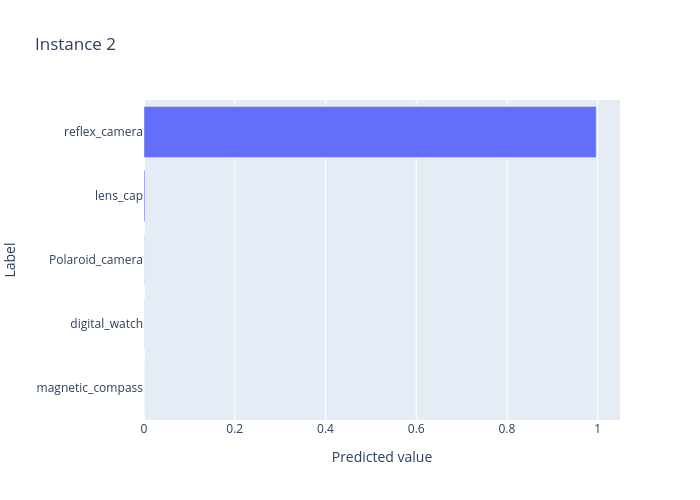

gradcam:


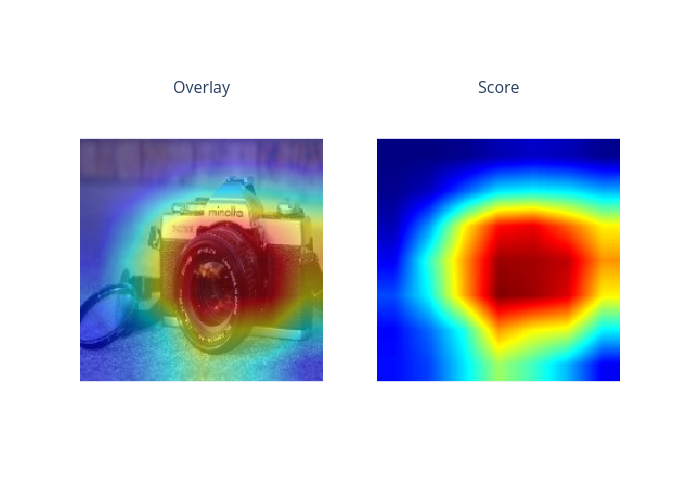

lime:


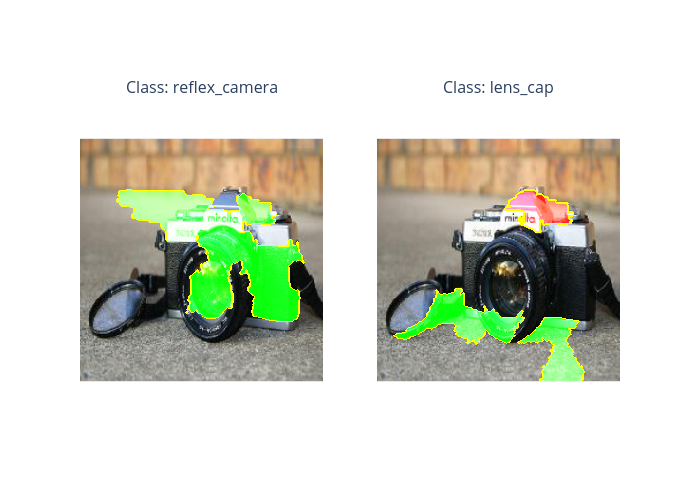

ig:


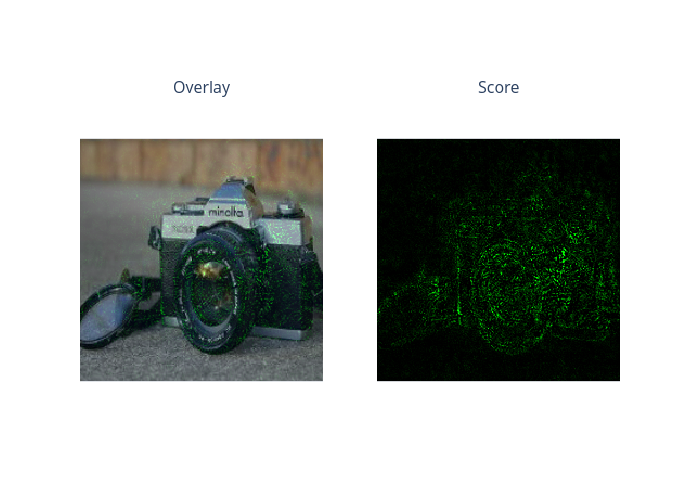

ce:


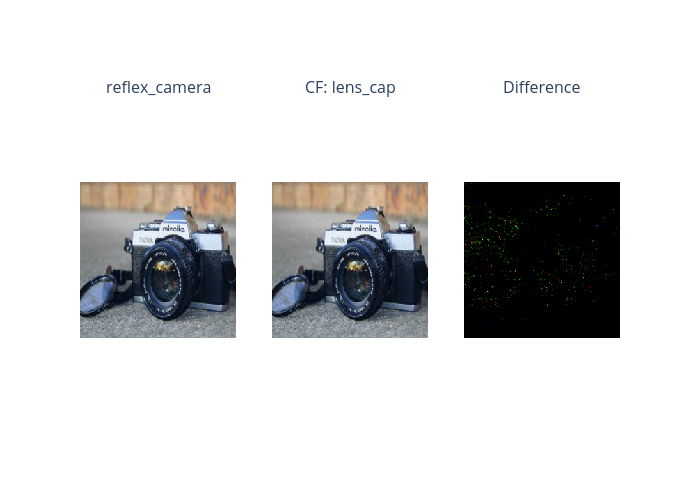

scorecam:


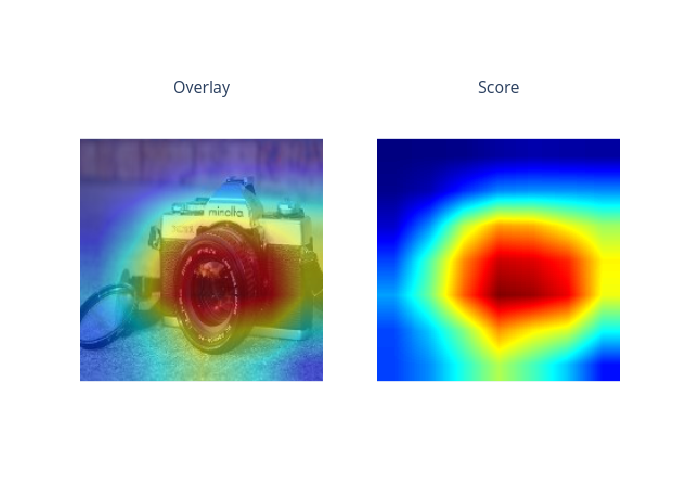

smoothgrad:


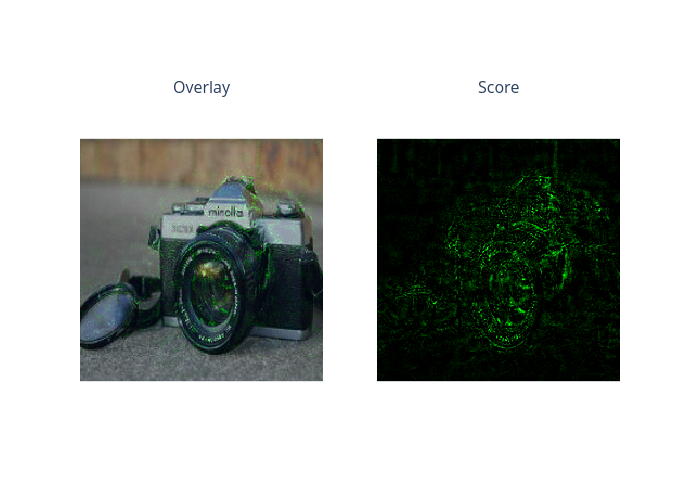

guidedbp:


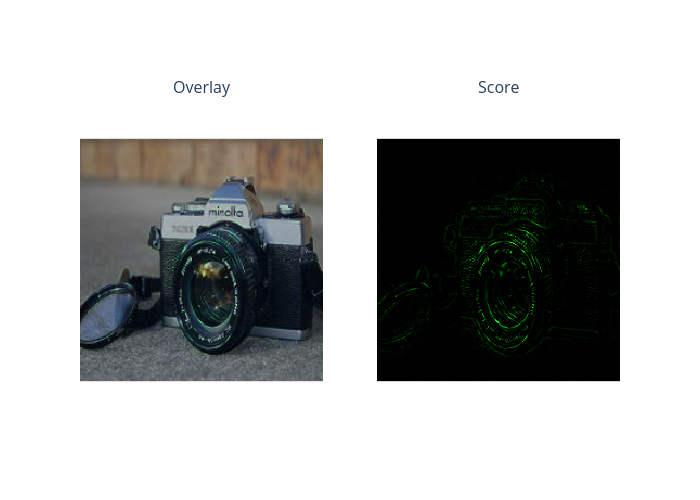

layercam:


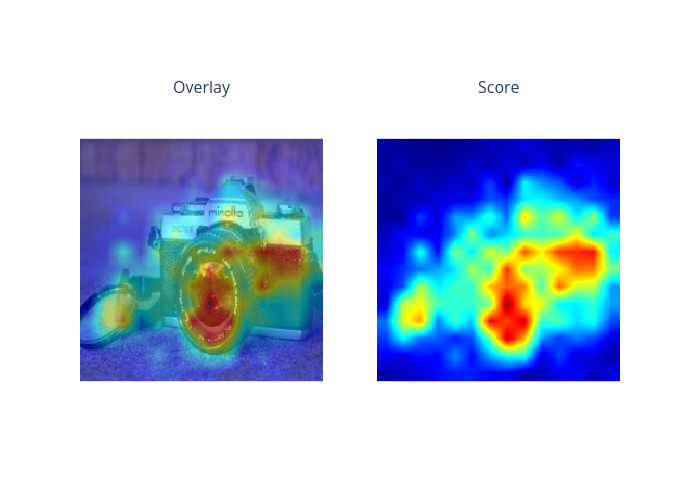

In [ ]:
index=2
for name, explanations in local_explanations.items():
    print(f"{name}:")
    explanations.ipython_plot(index, class_names=idx2label)

Given the generated explanations, we can launch a dashboard (a Dash app) for visualization by setting the test instance, the generated local explanations, and the class names.

In [8]:
# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=img,
    local_explanations=local_explanations,
    class_names=idx2label,
)
dashboard.show()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "omnixai.visualization.dashboard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
